# Traffic Sign Classifier

## Overview

This project is for building traffic sign classifier using deep convolutional neural network.

## Notes

 * The dataset used in this project is [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

---
##  Load The Data

In [2]:
import pickle
import numpy as np

training_file = './traffic-signs-data/train.p' 
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p' 

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration


In [3]:
n_train = X_train.shape[0] 
n_validation = X_valid.shape[0] 
n_test = X_test.shape[0]
image_shape = X_train.shape[1:] 
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

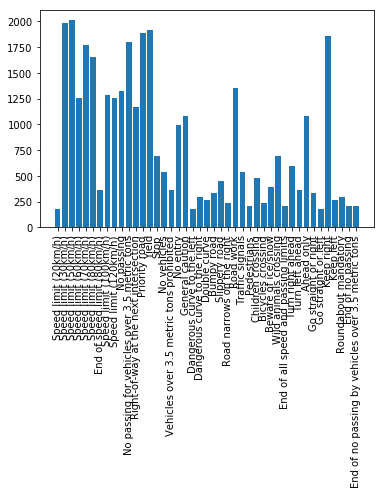

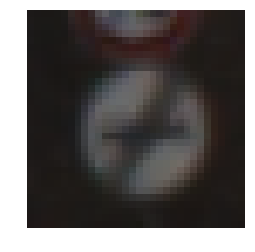

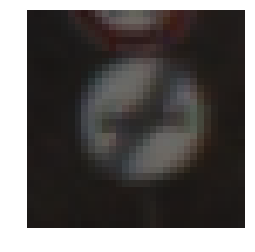

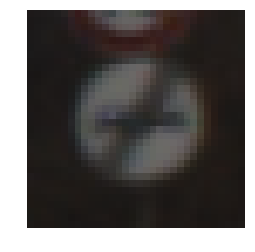

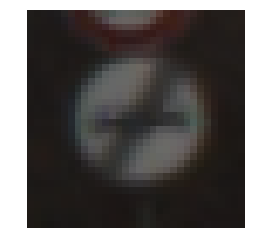

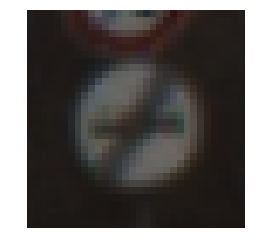

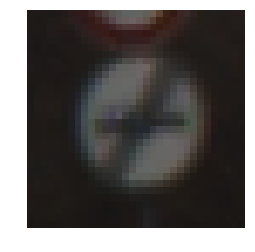

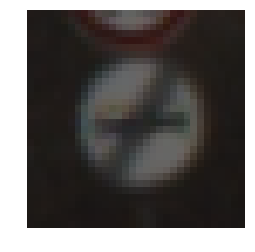

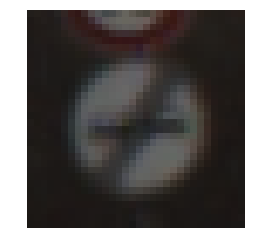

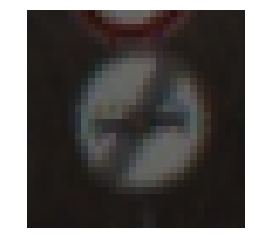

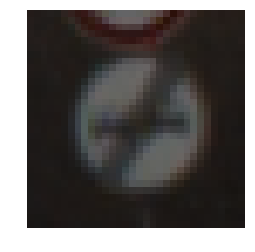

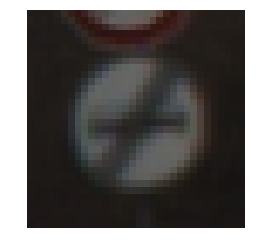

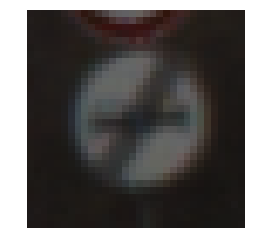

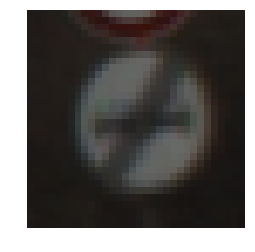

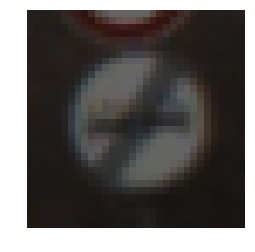

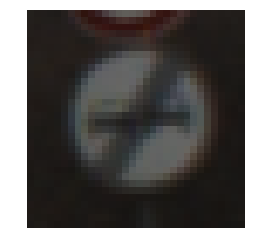

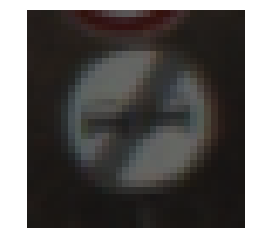

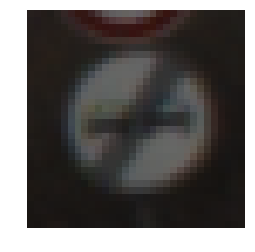

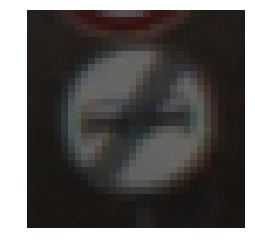

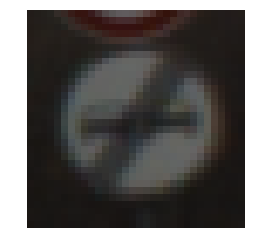

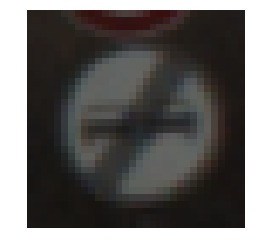

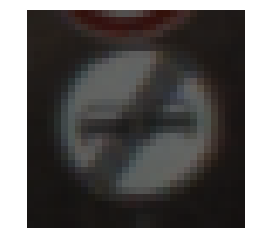

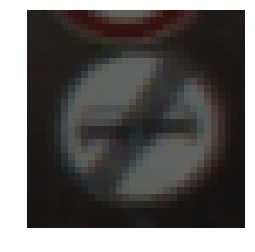

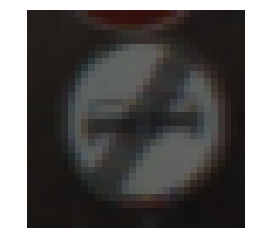

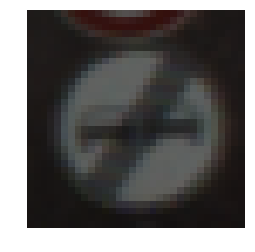

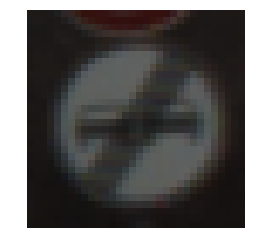

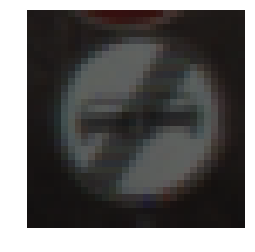

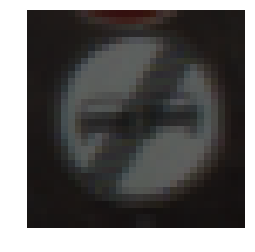

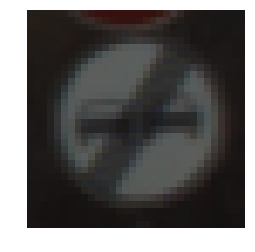

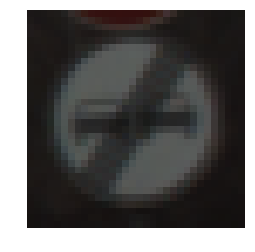

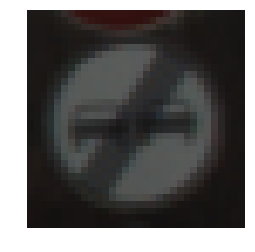

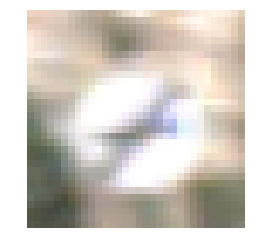

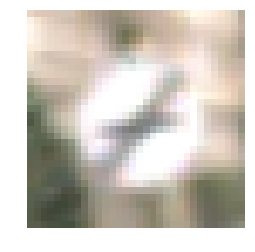

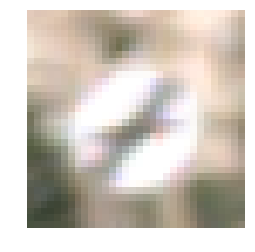

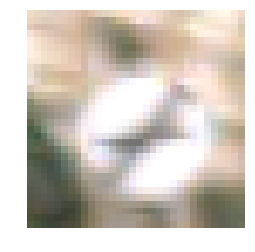

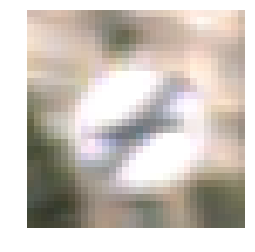

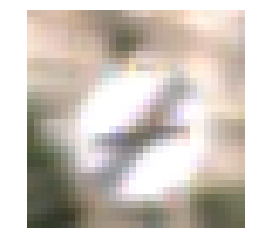

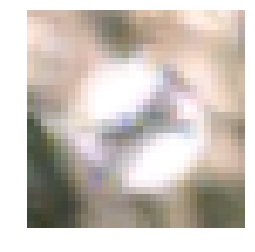

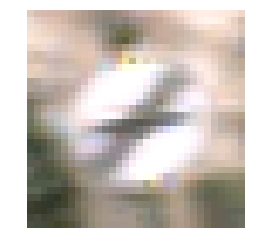

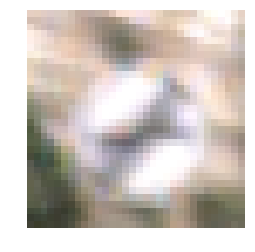

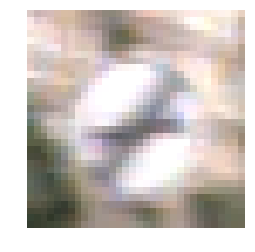

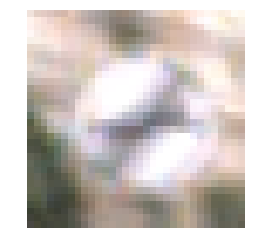

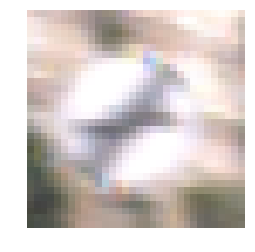

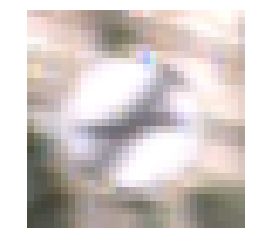

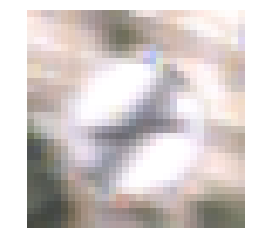

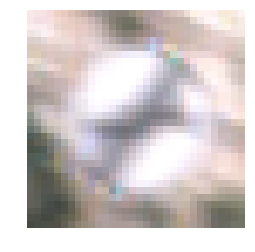

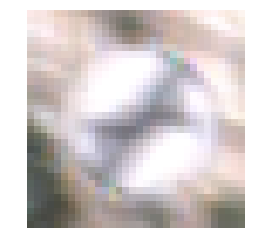

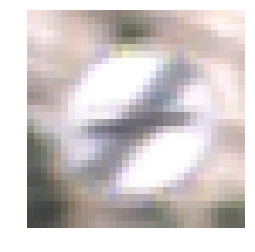

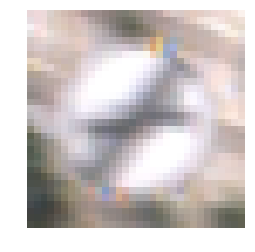

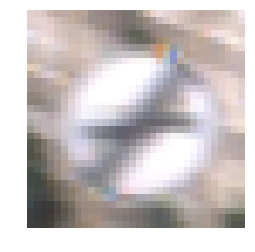

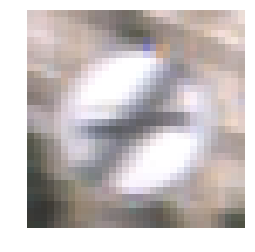

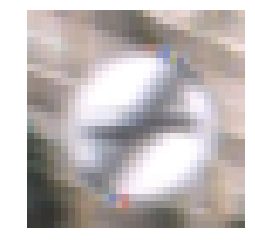

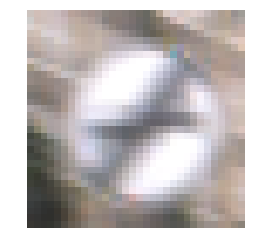

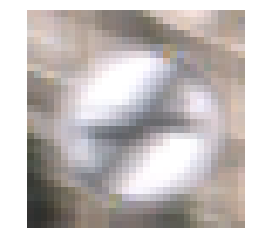

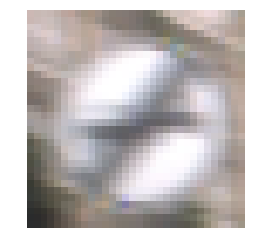

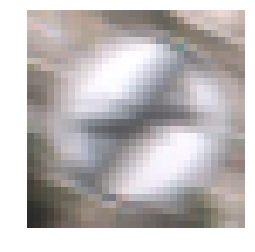

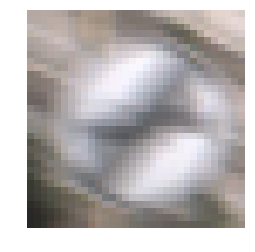

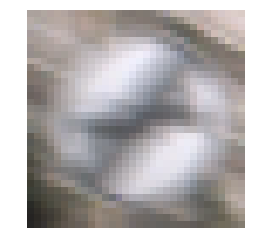

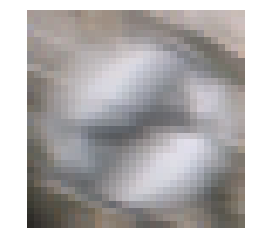

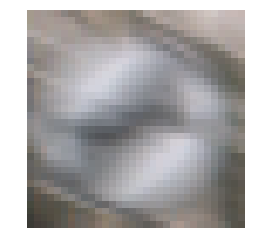

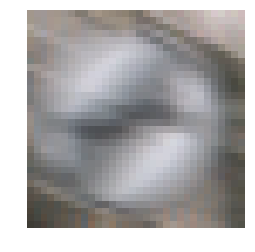

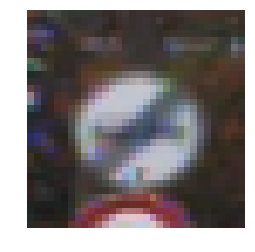

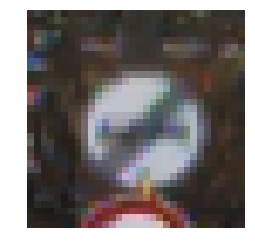

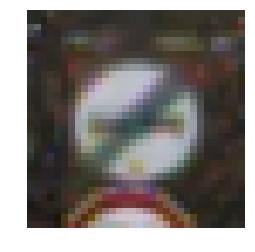

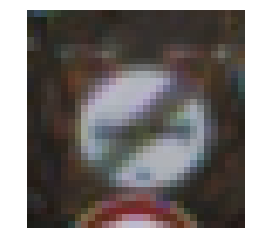

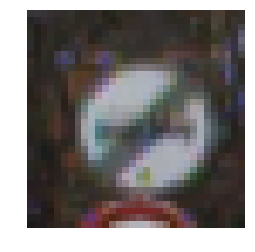

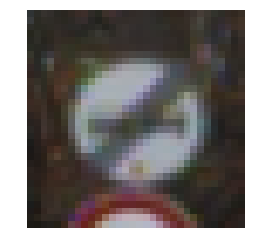

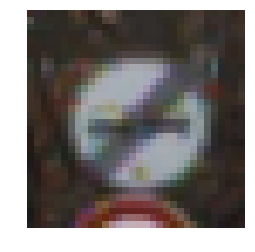

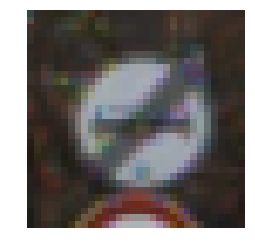

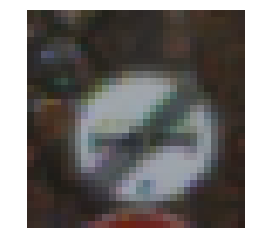

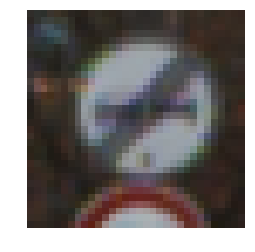

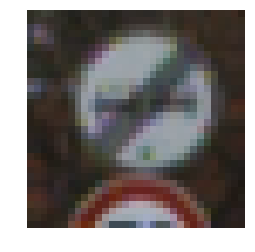

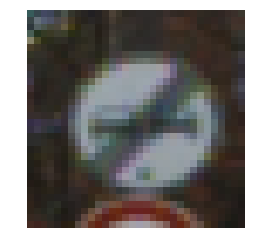

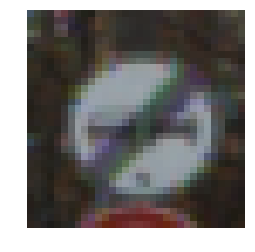

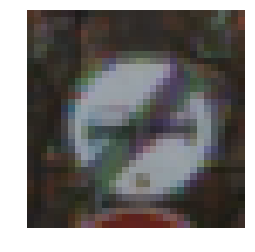

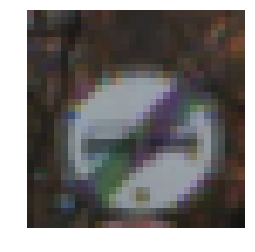

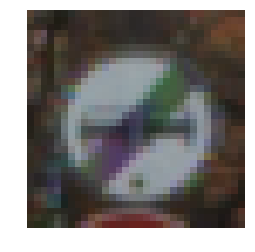

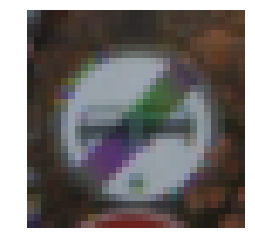

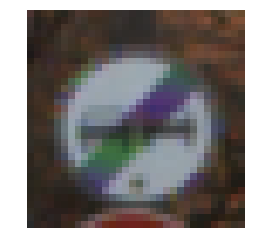

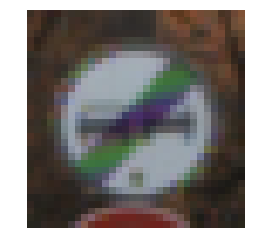

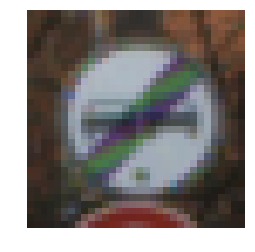

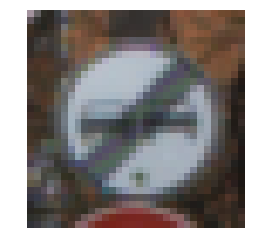

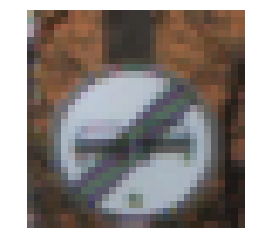

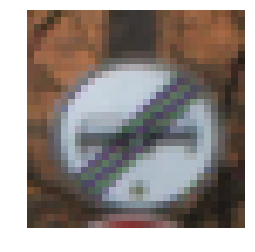

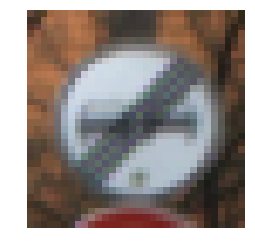

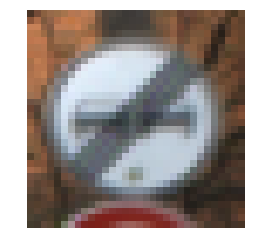

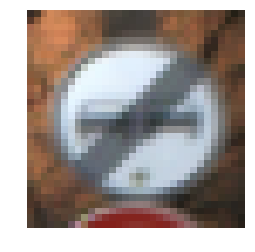

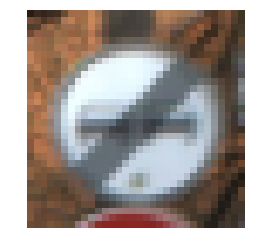

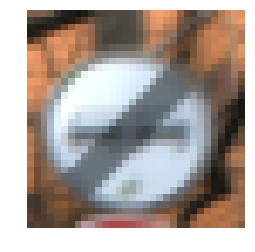

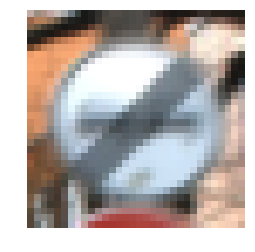

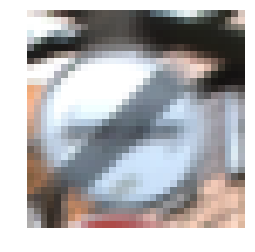

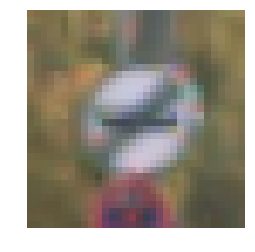

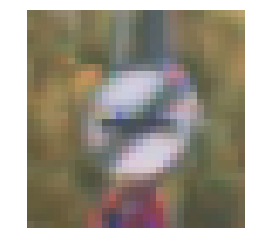

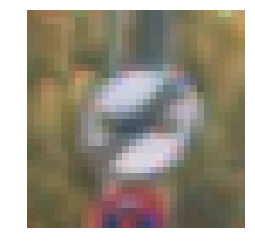

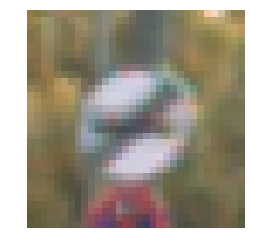

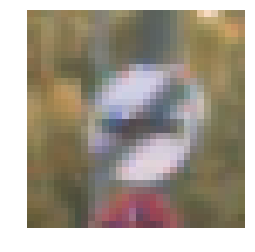

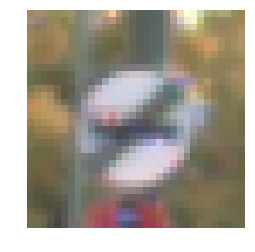

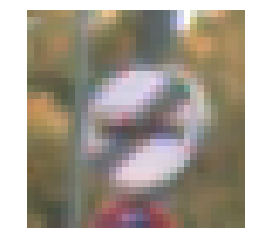

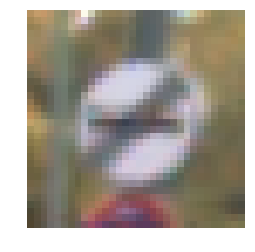

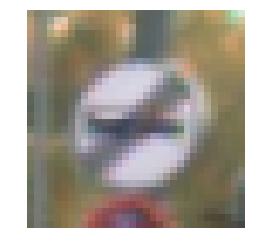

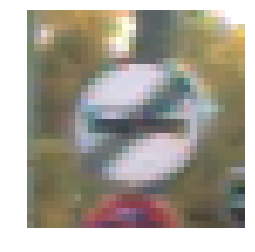

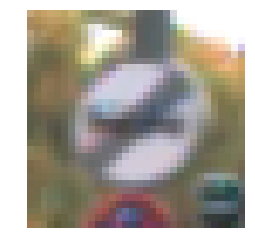

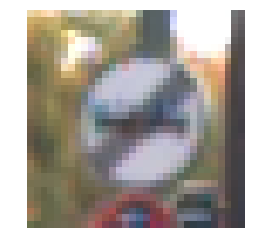

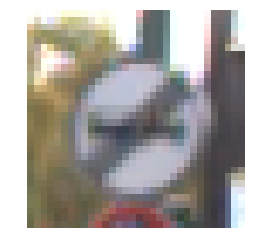

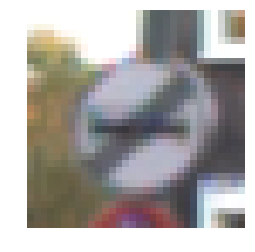

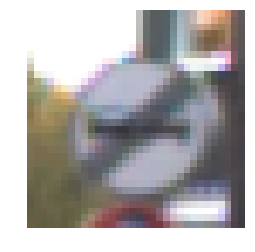

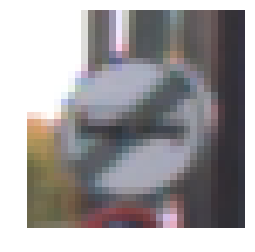

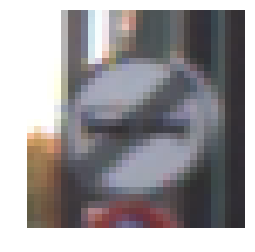

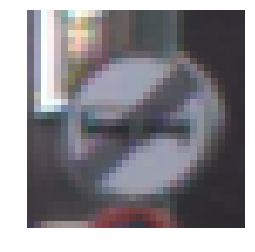

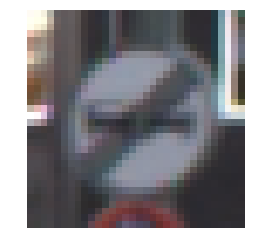

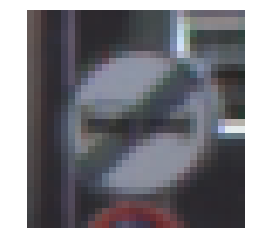

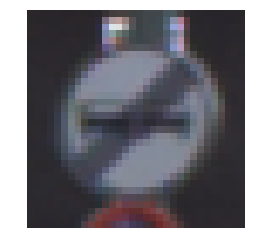

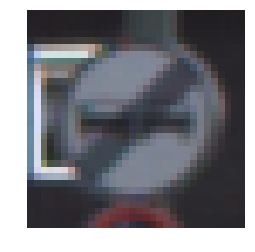

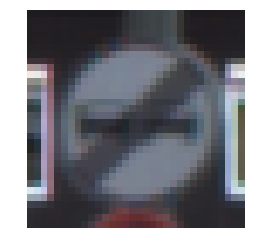

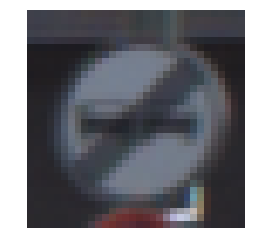

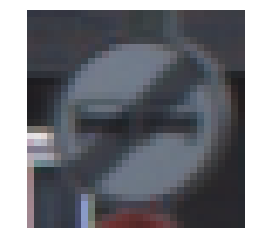

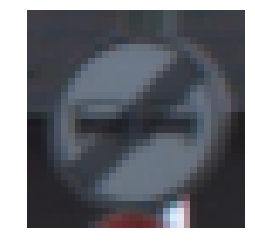

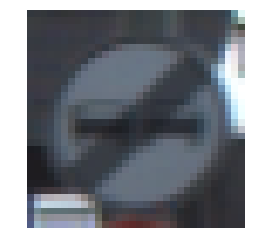

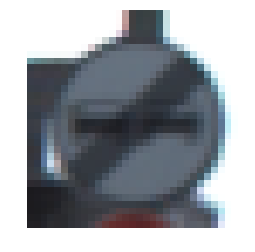

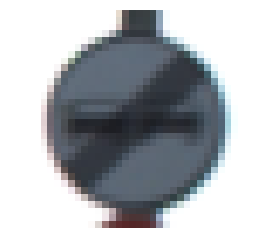

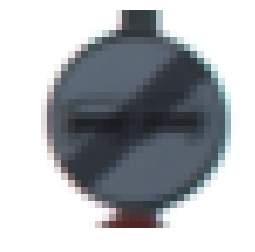

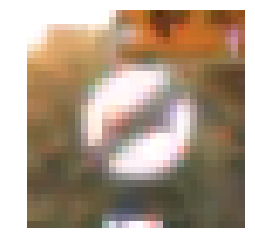

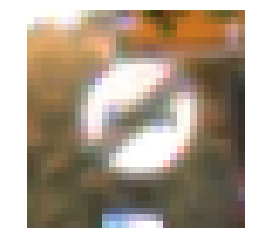

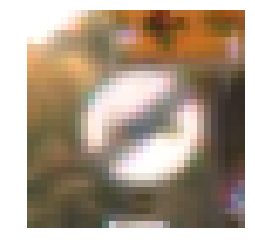

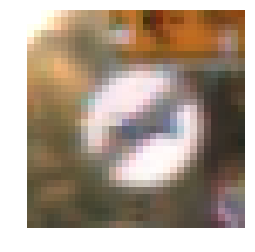

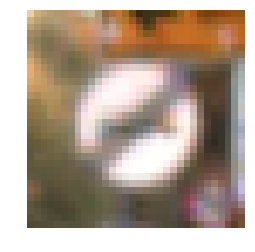

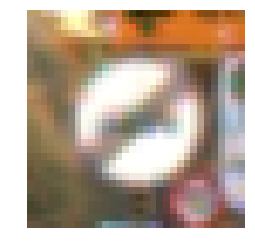

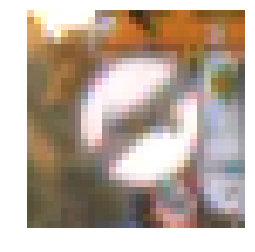

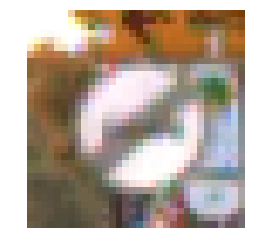

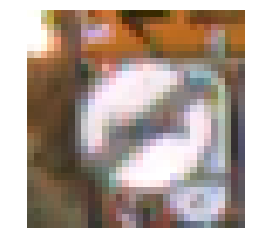

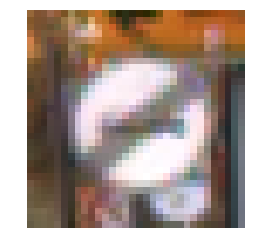

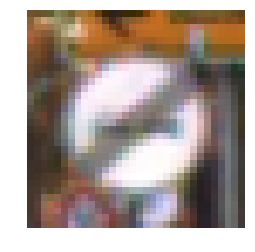

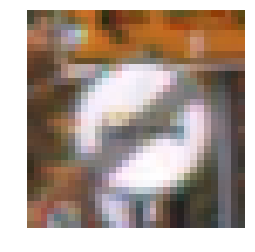

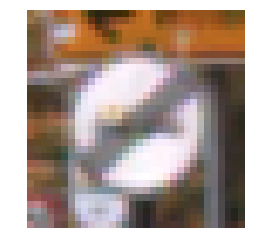

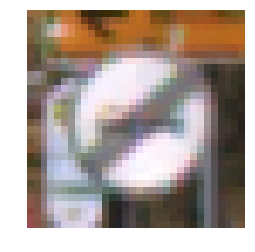

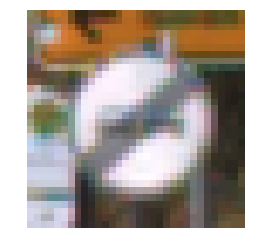

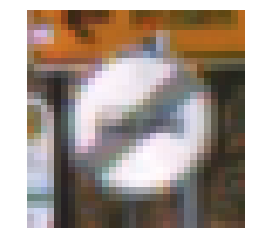

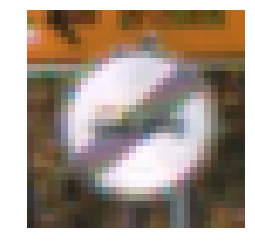

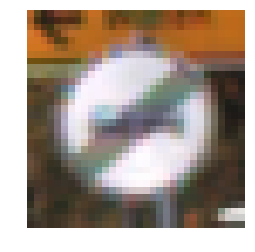

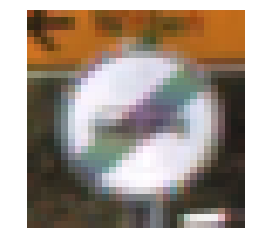

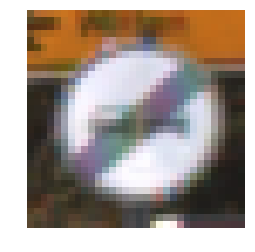

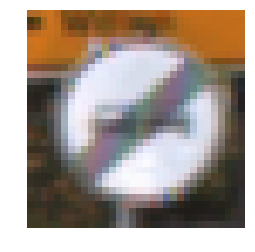

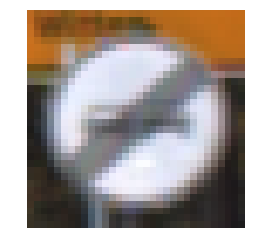

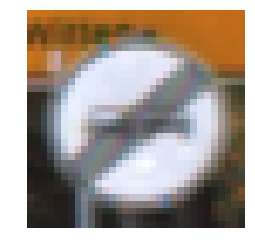

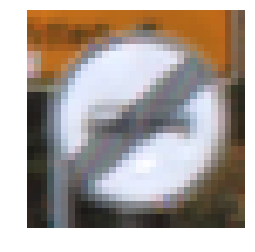

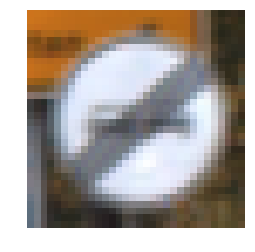

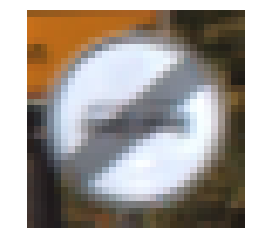

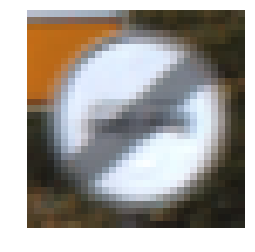

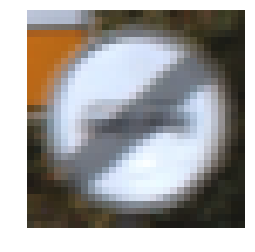

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

signs_names = []
df = pd.read_csv('./signnames.csv')
for name in df['SignName']:
    signs_names.append(name)

app_times = np.unique(y_train, return_counts=True)
plt.xticks(rotation=90)
plt.bar(app_times[0], app_times[1], tick_label=signs_names)    
plt.show()

for image in X_train:
    plt.axis("off")
    plt.imshow(image)
    plt.show()   
%matplotlib inline


----

## Design and Test a Model Architecture


### Pre-process the Data Set 

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
from sklearn.utils import shuffle

def normalize(image):
    normalized = (image.astype(np.float32) - 128) / 128
    return normalized

X_train = normalize(X_train)
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [5]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def LeNet(x):    
    mu = 0
    sigma = 0.1

    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    
    fc0   = flatten(conv3)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc1    = tf.nn.relu(fc1)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.dropout(fc2, keep_prob)
    fc2    = tf.nn.relu(fc2)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

In [6]:
EPOCHS = 40 
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,  n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.00096

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    validation_accuracy_figure = []
    train_accuracy_figure = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_figure.append(validation_accuracy)
        
        train_accuracy = evaluate(X_train, y_train)
        train_accuracy_figure.append(train_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.749
Validation Accuracy = 0.658

EPOCH 2 ...
Train Accuracy = 0.902
Validation Accuracy = 0.778

EPOCH 3 ...
Train Accuracy = 0.947
Validation Accuracy = 0.861

EPOCH 4 ...
Train Accuracy = 0.966
Validation Accuracy = 0.890

EPOCH 5 ...
Train Accuracy = 0.975
Validation Accuracy = 0.896

EPOCH 6 ...
Train Accuracy = 0.983
Validation Accuracy = 0.917

EPOCH 7 ...
Train Accuracy = 0.986
Validation Accuracy = 0.908

EPOCH 8 ...
Train Accuracy = 0.990
Validation Accuracy = 0.921

EPOCH 9 ...
Train Accuracy = 0.993
Validation Accuracy = 0.934

EPOCH 10 ...
Train Accuracy = 0.992
Validation Accuracy = 0.917

EPOCH 11 ...
Train Accuracy = 0.997
Validation Accuracy = 0.939

EPOCH 12 ...
Train Accuracy = 0.997
Validation Accuracy = 0.932

EPOCH 13 ...
Train Accuracy = 0.997
Validation Accuracy = 0.925

EPOCH 14 ...
Train Accuracy = 0.997
Validation Accuracy = 0.926

EPOCH 15 ...
Train Accuracy = 0.997
Validation Accuracy = 0.930

EPOCH 16 ...
Train Ac

---

## Test a Model on New Images

### Load and Output the Images

<function matplotlib.pyplot.show>

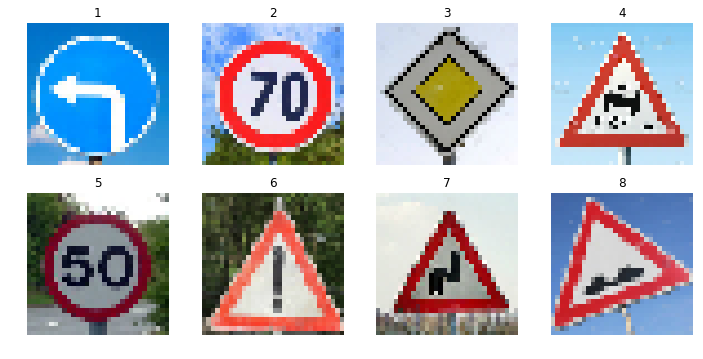

In [23]:
import glob
import cv2


# load test images
test_img_paths = [img_path for img_path in glob.glob("/newimages/*")]
num_test_img = len(test_img_paths)
test_img=np.uint8(np.zeros((num_test_img,32,32,3)))
for i, imp in enumerate(test_img_paths):
    img = cv2.imread(imp)
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
    test_img[i]=img

# plot images
figsize = (12, 12)
plt.figure(figsize=figsize)
for i in range(num_test_img):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_img[i]) 
    plt.title(i+1)
    plt.axis('off')
plt.show

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./lenet


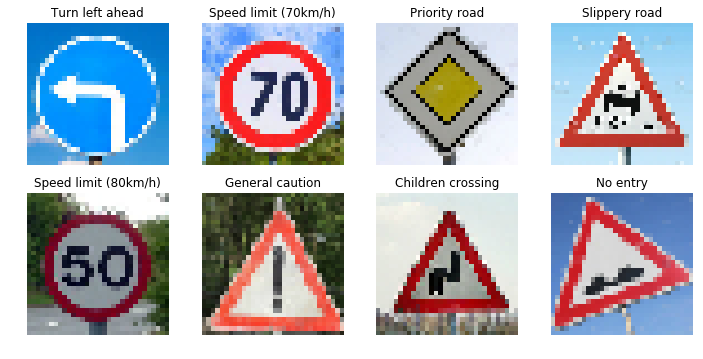

In [24]:
test_data=np.uint8(np.zeros((8,32,32,3)))
for i in range(num_test_img):
    test_data[i] = test_img[i]
    
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    signs_classes = sess.run(tf.argmax(logits, 1), feed_dict={x: test_data, keep_prob: 1.0})

figsize = (12,12)
plt.figure(figsize=figsize)
for i in range(num_test_img):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_img[i]) 
    plt.title(signs_names[signs_classes[i]])
    plt.axis('off')
plt.show()

### Analyze Performance

In [25]:
correct_classes = [34, 4, 12, 23, 2, 18, 21, 22]

right_cnt = 0
for (correct, predicted) in zip(correct_classes, signs_classes):
    if correct == predicted:
        right_cnt += 1

print("Accuracy: ", round(right_cnt / num_test_img, 3))

Accuracy:  0.625


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./lenet


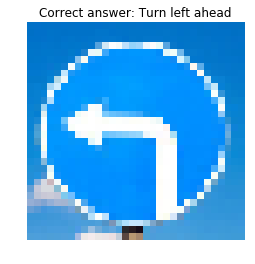

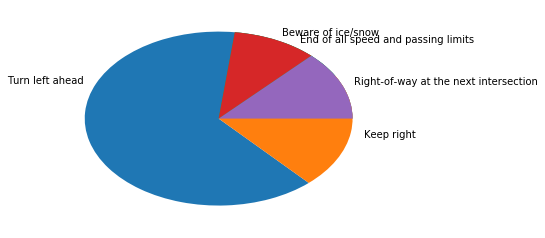

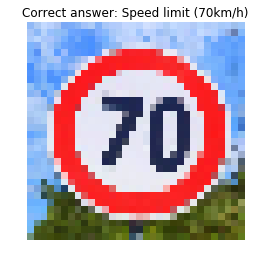

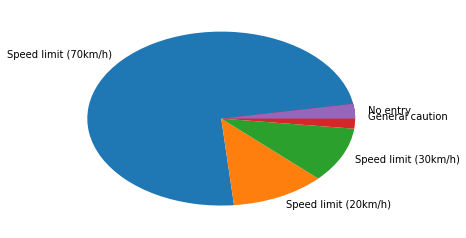

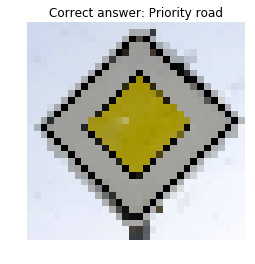

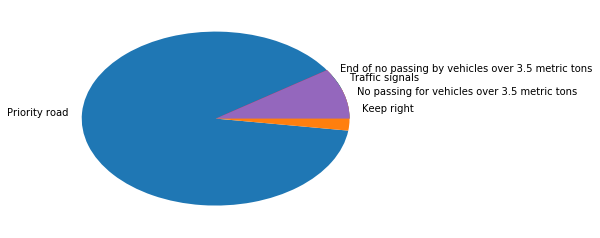

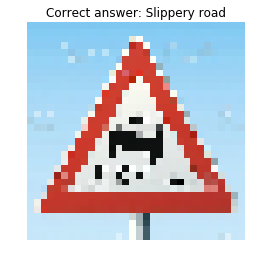

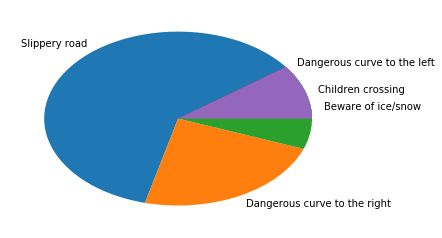

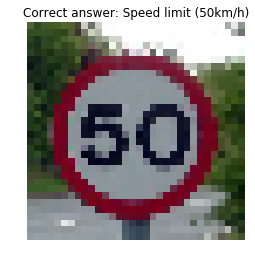

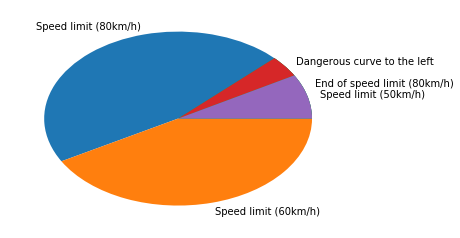

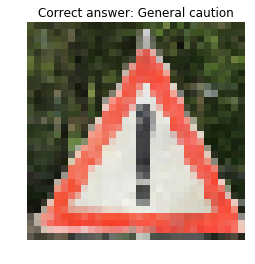

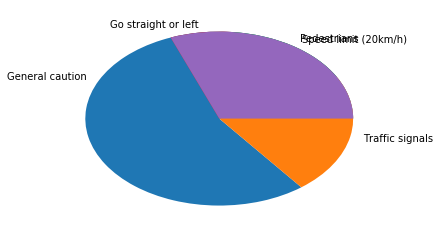

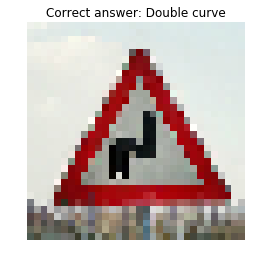

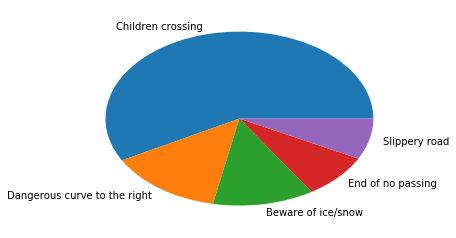

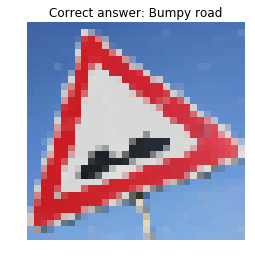

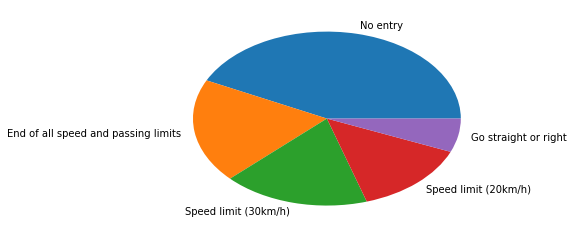

In [26]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    top_probs = sess.run(tf.nn.top_k(logits  , k=5)  , feed_dict={x: test_data, keep_prob: 1.0})

prob_names = []
for prob in top_probs[1]:
    names = []
    for id in prob:
        names.append(signs_names[id])
    prob_names.append(names)
    
for i in range(num_test_img):
    plt.imshow(test_img[i]) 
    plt.title("Correct answer: " + signs_names[correct_classes[i]])
    plt.axis('off')
    plt.show()
    plt.pie(top_probs[0][i], labels=prob_names[i])
    plt.show()
